In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),  # Optional, for square images
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(root='F:/Vit_Bhopal_Mtech/subjects/Winter_Semester/deep_learning/archive', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VQ-VAE model
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.commitment_cost = commitment_cost

    def forward(self, z):
        z_flattened = z.view(-1, z.shape[-1])  # Ensure the last dimension is retained
        distances = (torch.sum(z_flattened ** 2, dim=1, keepdim=True)
                     + torch.sum(self.embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(z_flattened, self.embedding.weight.t()))
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.embedding(encoding_indices).view(z.shape)
        loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2) + torch.mean((z_q - z.detach()) ** 2)
        return z_q, loss, encoding_indices

class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Further reduce spatial dimensions
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 8 * 8, embedding_dim)  # Project to the desired embedding dimension
        )
        self.vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost=0.25)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128 * 8 * 8),  # Match the intermediate size after encoder
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),  # Reshape to match spatial dimensions
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upscale to 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upscale to 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Upscale to 64x64
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, encoding_indices = self.vector_quantizer(z_e)
        reconstructed = self.decoder(z_q)
        return reconstructed, vq_loss



# Load dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='F:/Vit_Bhopal_Mtech/subjects/Winter_Semester/deep_learning/archive', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE(num_embeddings=512, embedding_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):  # Set number of epochs
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, vq_loss = model(images)
        recon_loss = nn.MSELoss()(reconstructed, images)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Defect Detection
# Compute reconstruction error for a new batch of images
def detect_defects(model, images):
    model.eval()
    with torch.no_grad():
        reconstructed, _ = model(images)
        errors = nn.MSELoss(reduction='none')(reconstructed, images)
        mean_error = errors.view(errors.size(0), -1).mean(dim=1)
        return mean_error

# Example usage
images, _ = next(iter(dataloader))
errors = detect_defects(model, images.to(device))


Epoch 0, Loss: 0.7914623022079468
Epoch 0, Loss: 0.45454779267311096
Epoch 0, Loss: 0.3504618704319
Epoch 0, Loss: 0.11442065238952637
Epoch 0, Loss: 0.10627202689647675
Epoch 0, Loss: 0.10180377215147018
Epoch 1, Loss: 0.09994205832481384
Epoch 1, Loss: 0.11608283966779709
Epoch 1, Loss: 0.07396889477968216
Epoch 1, Loss: 0.0673520416021347
Epoch 1, Loss: 0.057730965316295624
Epoch 1, Loss: 0.0575733408331871
Epoch 2, Loss: 0.05105748772621155
Epoch 2, Loss: 0.06440536677837372
Epoch 2, Loss: 0.047853972762823105
Epoch 2, Loss: 0.04693550616502762
Epoch 2, Loss: 0.046808354556560516
Epoch 2, Loss: 0.039508115500211716
Epoch 3, Loss: 0.03704013675451279
Epoch 3, Loss: 0.046620383858680725
Epoch 3, Loss: 0.03619835153222084
Epoch 3, Loss: 0.034057702869176865
Epoch 3, Loss: 0.04032827168703079
Epoch 3, Loss: 0.04595226049423218
Epoch 4, Loss: 0.030472401529550552
Epoch 4, Loss: 0.03929973766207695
Epoch 4, Loss: 0.03456191346049309
Epoch 4, Loss: 0.030562443658709526
Epoch 4, Loss: 0.03

Epoch 0, Average Loss: 0.02649794891476631
Epoch 1, Average Loss: 0.025805236771702766
Epoch 2, Average Loss: 0.0255501593152682
Epoch 3, Average Loss: 0.02620878287901481
Epoch 4, Average Loss: 0.025853593833744526
Epoch 5, Average Loss: 0.02584429985533158
Epoch 6, Average Loss: 0.0258502218251427
Epoch 7, Average Loss: 0.024808385409414768
Epoch 8, Average Loss: 0.024809252160290878
Epoch 9, Average Loss: 0.025796439809103806


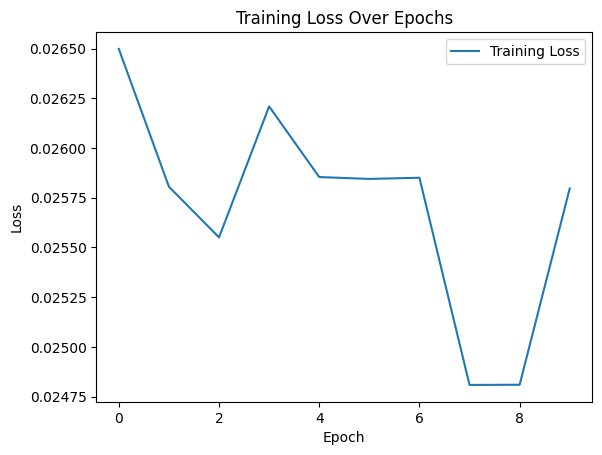

In [11]:
import matplotlib.pyplot as plt

# Track losses during training
losses = []

for epoch in range(10):  # Set number of epochs
    epoch_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, vq_loss = model(images)
        recon_loss = nn.MSELoss()(reconstructed, images)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))  # Average loss per epoch
    print(f'Epoch {epoch}, Average Loss: {losses[-1]}')

# Plot training loss
plt.plot(range(len(losses)), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


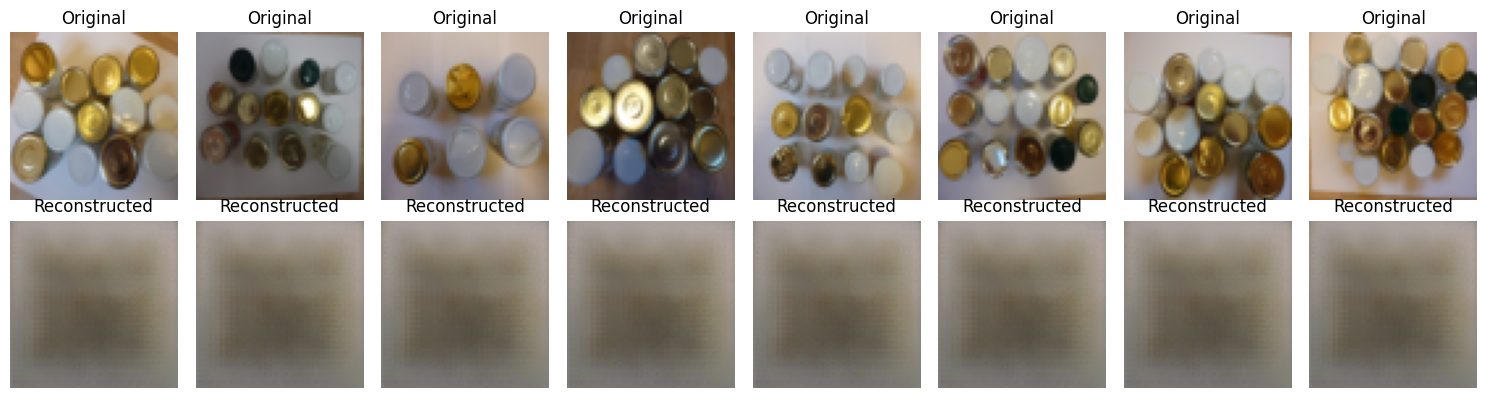

In [12]:
def plot_reconstruction(model, dataloader):
    model.eval()
    images, _ = next(iter(dataloader))
    with torch.no_grad():
        reconstructed, _ = model(images.to(device))

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # Original images
        axes[0, i].imshow(images[i].permute(1, 2, 0).numpy())
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        # Reconstructed images
        axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0).numpy())
        axes[1, i].axis("off")
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

plot_reconstruction(model, dataloader)


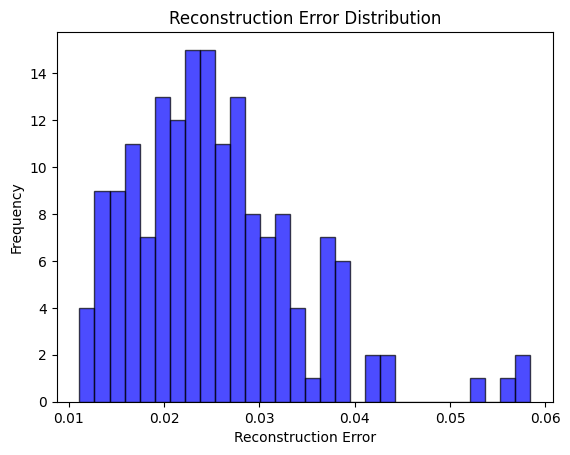

In [13]:
import numpy as np

def plot_error_distribution(model, dataloader):
    model.eval()
    errors = []
    for images, _ in dataloader:
        images = images.to(device)
        with torch.no_grad():
            reconstructed, _ = model(images)
            error = nn.MSELoss(reduction='none')(reconstructed, images)
            mean_error = error.view(error.size(0), -1).mean(dim=1)
            errors.extend(mean_error.cpu().numpy())

    # Plot distribution of errors
    plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Reconstruction Error Distribution")
    plt.show()

plot_error_distribution(model, dataloader)


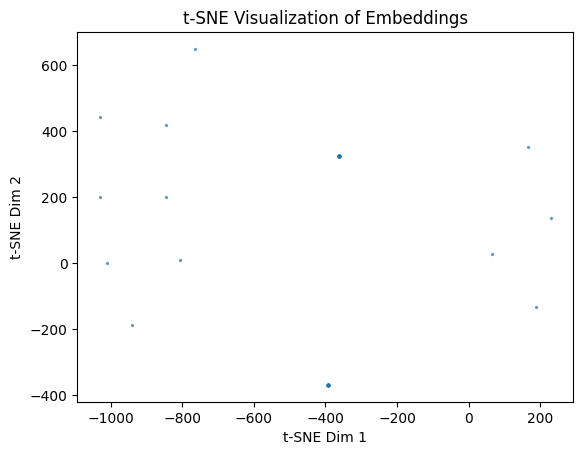

In [14]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings(model, dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            z_e = model.encoder(images)
            _, _, encoding_indices = model.vector_quantizer(z_e)
            embeddings.extend(model.vector_quantizer.embedding(encoding_indices).cpu().numpy())

    embeddings = np.array(embeddings)
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=2, alpha=0.6)
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

visualize_embeddings(model, dataloader)


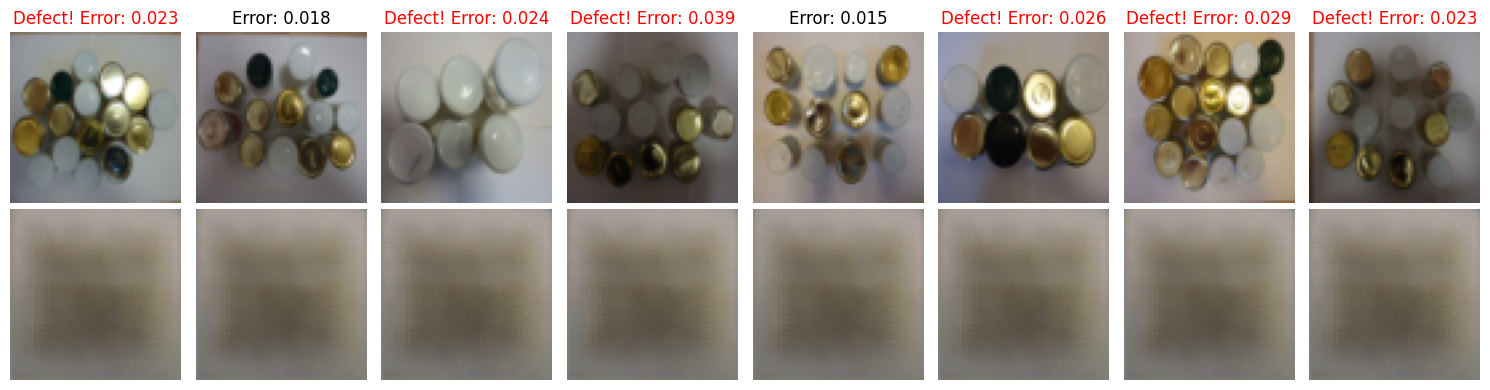

In [15]:
def highlight_defects(model, dataloader, threshold=0.02):
    model.eval()
    images, _ = next(iter(dataloader))
    with torch.no_grad():
        reconstructed, _ = model(images.to(device))
        errors = nn.MSELoss(reduction='none')(reconstructed, images.to(device))
        mean_errors = errors.view(errors.size(0), -1).mean(dim=1).cpu().numpy()

    # Highlight defective images
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # Original image
        axes[0, i].imshow(images[i].permute(1, 2, 0).numpy())
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Error: {mean_errors[i]:.3f}")

        # Reconstructed image
        axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0).numpy())
        axes[1, i].axis("off")

        # Mark defect
        if mean_errors[i] > threshold:
            axes[0, i].set_title(f"Defect! Error: {mean_errors[i]:.3f}", color='red')

    plt.tight_layout()
    plt.show()

highlight_defects(model, dataloader)
